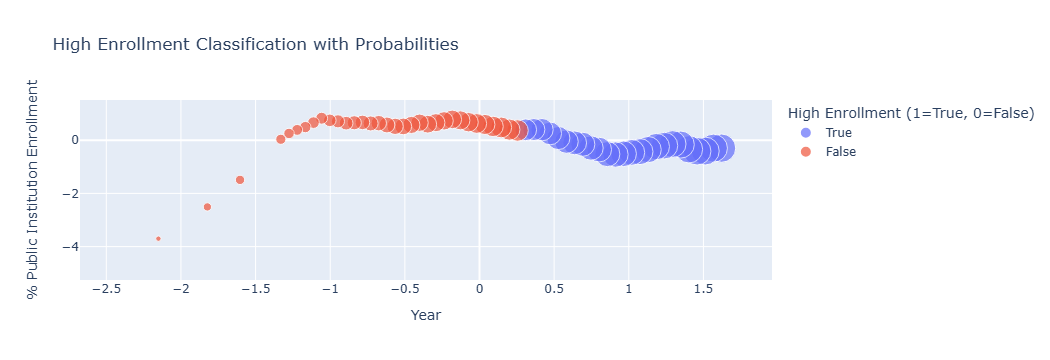

In [1]:
# The scatter plot created in the example is based on a dataset where the relationship between Year,
# Total Enrollment, and Probability is visualized. 

import pandas as pd
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier


def scrap_table(num):
    # URL of the webpage with the table
    url = "https://educationdata.org/college-enrollment-statistics"
    response = requests.get(url)

    # Parsing the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Finding all the tables
    tables = soup.find_all('table', {'class': 'table-responsive-mobile'})

    #finding 
    ethnic_table = tables[num]

    # Extract the table headers
    headers = [th.text.strip() for th in ethnic_table.find_all('th')]

    # Extract the table rows (skipping the header)
    rows = []
    
    # Skip the header row
    for row in ethnic_table.find_all('tr')[1:]: 
        cells = [cell.text.strip() for cell in row.find_all('td')]
        rows.append(cells)

    # Put into variable
    df = pd.DataFrame(rows, columns=headers)
    
    return df

enrollment_df = scrap_table(0)

# target for classification
enrollment_df['High Enrollment'] = (enrollment_df['Total Enrollment'].str.replace(',', '').astype(int) > 15000000)
enrollment_df['Year'] = enrollment_df['Year'].str.replace('(Projected)', '')
enrollment_df['% Public Institution Enrollment'] = enrollment_df['% Public Institution Enrollment'].str.replace('%','')

# standardize features
scaler = StandardScaler()
df_scaled = enrollment_df.copy()
df_scaled[['Year', '% Public Institution Enrollment']] = scaler.fit_transform(
    enrollment_df[['Year', '% Public Institution Enrollment']])

# train-test split
X = df_scaled[['Year', '% Public Institution Enrollment']]
y = df_scaled['High Enrollment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the classifier
clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)

# predict probabilities vis & normalize the prov col to [0, inf] 
df_scaled['Probability'] = clf.decision_function(df_scaled[['Year', '% Public Institution Enrollment']])
scaler = MinMaxScaler(feature_range=(0, 100))  
df_scaled['Probability'] = scaler.fit_transform(df_scaled[['Probability']])

# scatter plot
fig = px.scatter(df_scaled, x='Year', y='% Public Institution Enrollment',
                 color='High Enrollment',
                 size='Probability',
                 title='High Enrollment Classification with Probabilities',
                 labels={'High Enrollment': 'High Enrollment (1=True, 0=False)'},
                 color_continuous_scale=px.colors.sequential.Viridis)
fig.update_traces(marker=dict(opacity=0.7))
fig.show()